# 185. 네이버 영화평 감성 분류

- 한글 형태소 분석기 Okt 사용 전처리  

- Keras Tokenizer, pad_sequences 함수 사용

In [2]:
pip install KoNLPy

     |████████████████████████████████| 19.4MB 169kB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
     |████████████████████████████████| 3.6MB 47.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [0]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt

from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM

In [4]:
DATA_TRAIN_PATH = tf.keras.utils.get_file("ratings_train.txt", 
                                "https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_train.txt")
DATA_TEST_PATH = tf.keras.utils.get_file("ratings_test.txt", 
                                "https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_test.txt")

4947968/4943336 [==============================] - 0s 0us/step


In [5]:
train_data = pd.read_csv(DATA_TRAIN_PATH, delimiter='\t')
print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
test_data = pd.read_csv(DATA_TEST_PATH, delimiter='\t')
print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 훈련 시간을 감안하여 data size 축소

In [7]:
train_data = train_data.sample(n=50000, random_state=1)
test_data = test_data.sample(n=5000, random_state=1)

print(train_data.shape)
print(test_data.shape)

(50000, 3)
(5000, 3)


**null value 제거**

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 58397 to 71565
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [0]:
train_data.dropna(inplace=True)

In [0]:
test_data.dropna(inplace=True)

In [11]:
okt = Okt()
test = "아버지가방에들어가신다"
okt.morphs(test)

['아버지', '가방', '에', '들어가신다']

## Text Data 전처리

**한글 문자가 아닌 것 모두 제거**

In [0]:
def preprocessing(sentence, remove_stopwords=True):
    # 불용어 제거
    #stop_words = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    stop_words = []
    
    sentence = re.sub('\\\\n', ' ', sentence)              # 개행문자 제거
    sentence = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', "", sentence)  #한글외에 모두 제거
    sentence = okt.morphs(sentence, stem=True)
    if remove_stopwords:
        sentence = [token for token in sentence if not token in stop_words]
    return sentence

In [13]:
%%time

clean_train = []
train_labels = []
clean_test = []
test_labels = []

start = time.time()

for i, (sent, label) in enumerate(zip(train_data['document'], train_data['label'])):
    if i % 10000 == 0:
        print(f"processed = {i}")
    sent = preprocessing(sent)
    if len(sent) > 0:
        clean_train.append(sent)
        train_labels.append(label)

for i, (sent, label) in enumerate(zip(test_data['document'], test_data['label'])):
    if i % 10000 == 0:
        print(f"processed = {i}")
    sent = preprocessing(sent)
    if len(sent) > 0:
        clean_test.append(sent)
        test_labels.append(label)
    
print(time.time() - start)

processed = 0
processed = 10000
processed = 20000
processed = 30000
processed = 40000
processed = 0
167.23960137367249
CPU times: user 2min 57s, sys: 529 ms, total: 2min 58s
Wall time: 2min 47s


In [14]:
print(len(clean_train))
print(len(train_labels))
print(len(clean_test))
print(len(test_labels))

49571
49571
4951
4951


In [0]:
VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(clean_train)

train_sequences = tokenizer.texts_to_sequences(clean_train)
test_sequences = tokenizer.texts_to_sequences(clean_test)

In [16]:
print(train_sequences[:5])
print()
print(test_sequences[:5])

[[90, 1370, 13, 1554, 80, 520, 8870, 14637, 29, 250, 5, 3884, 16, 430, 62, 210, 30, 1612, 14, 744, 22, 229, 6, 1123, 13, 31, 43, 12, 149, 2547, 5, 741, 12, 1554, 14638, 6007, 8871, 8872, 8, 31], [50, 4, 86, 21, 79, 466, 2263, 10, 57, 264], [629, 36, 10866, 53, 37, 165, 264, 9, 447, 385, 3, 349, 26, 7, 1842, 2, 765], [1283, 3, 479, 431, 163, 490, 77, 578, 13, 18, 3, 16], [458, 3885, 8, 2142, 63, 80, 35, 58, 446, 3, 10, 268, 9, 98, 4]]

[[1683, 7, 460, 1491, 106, 346, 37, 2485, 344, 760, 206, 650, 96, 270], [148, 4, 23, 111, 182, 13, 40, 2, 887, 84, 70], [107, 993, 3491, 102, 552, 654, 3, 505, 684, 596, 478], [101, 4, 3, 8, 31], [349, 26, 7, 480, 22, 378, 179, 731, 271, 607, 163, 238]]


sample max length : 78
sample mean length: 13


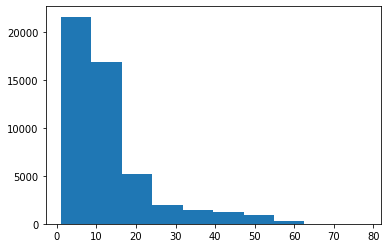

In [17]:
print('sample max length : {}'.format(max(len(s) for s in clean_train)))
print('sample mean length: {:.0f}'.format(np.mean([len(s) for s in clean_train])))

plt.hist([len(s) for s in clean_train]);

In [0]:
MAX_SEQUENCE_LENGTH = 15

In [19]:
train_inputs = pad_sequences(train_sequences, 
                                             maxlen=MAX_SEQUENCE_LENGTH,
                                             padding='post', truncating='post')
train_labels = np.array(train_labels)

test_inputs = pad_sequences(test_sequences, 
                                             maxlen=MAX_SEQUENCE_LENGTH,
                                             padding='post', truncating='post')
test_labels = np.array(test_labels)

len(train_inputs), len(train_labels), len(test_inputs), len(test_labels)

(49571, 49571, 4951, 4951)

In [20]:
print(train_inputs[:5])
print()
print(test_inputs[:5])

[[   90  1370    13  1554    80   520  8870 14637    29   250     5  3884
     16   430    62]
 [   50     4    86    21    79   466  2263    10    57   264     0     0
      0     0     0]
 [  629    36 10866    53    37   165   264     9   447   385     3   349
     26     7  1842]
 [ 1283     3   479   431   163   490    77   578    13    18     3    16
      0     0     0]
 [  458  3885     8  2142    63    80    35    58   446     3    10   268
      9    98     4]]

[[1683    7  460 1491  106  346   37 2485  344  760  206  650   96  270
     0]
 [ 148    4   23  111  182   13   40    2  887   84   70    0    0    0
     0]
 [ 107  993 3491  102  552  654    3  505  684  596  478    0    0    0
     0]
 [ 101    4    3    8   31    0    0    0    0    0    0    0    0    0
     0]
 [ 349   26    7  480   22  378  179  731  271  607  163  238    0    0
     0]]


### sequence 를 다시 문장으로 역변환

In [24]:
reverse_word_index = dict([(v, k) for (k, v) in tokenizer.word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(train_inputs[300]))

여전하다 매력 적 인 선장 잭 스패 로우 덕 에 탄력 받다 시리즈 ? ?


In [22]:
model = Sequential([
    Embedding(VOCAB_SIZE+1, 64),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1280064   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,350,273
Trainable params: 1,350,273
Non-trainable params: 0
_________________________________________________________________


In [25]:
num_epochs = 5
history = model.fit(train_inputs, train_labels, epochs=num_epochs,
                           batch_size=128, validation_data=(test_inputs, test_labels),
                           verbose=1)

Epoch 1/5
388/388 [==============================] - 7s 18ms/step - loss: 0.4524 - accuracy: 0.7790 - val_loss: 0.4037 - val_accuracy: 0.8182
Epoch 2/5
388/388 [==============================] - 6s 16ms/step - loss: 0.3260 - accuracy: 0.8605 - val_loss: 0.4069 - val_accuracy: 0.8180
Epoch 3/5
388/388 [==============================] - 6s 16ms/step - loss: 0.2621 - accuracy: 0.8892 - val_loss: 0.4404 - val_accuracy: 0.8202
Epoch 4/5
388/388 [==============================] - 6s 16ms/step - loss: 0.2120 - accuracy: 0.9108 - val_loss: 0.4965 - val_accuracy: 0.8190
Epoch 5/5
388/388 [==============================] - 6s 16ms/step - loss: 0.1770 - accuracy: 0.9255 - val_loss: 0.5410 - val_accuracy: 0.8107


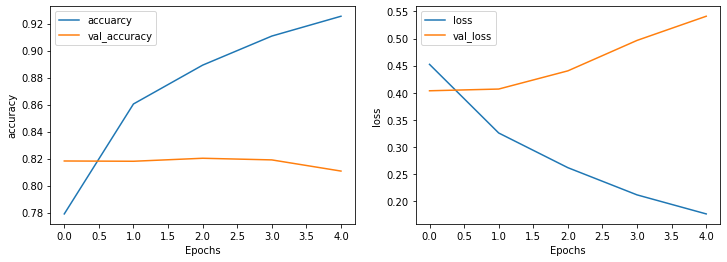

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [27]:
#sample_text = ['이 영화는 정말 짜증나서 못 보겠다']
sample_text = ['이렇게 감동적인 영화는 정말 간만이다']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
sample_padded

array([[115,   1,   1,  21,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [28]:
model.predict([sample_padded])

array([[0.7893692]], dtype=float32)